# Final Project - Click Through Rate Prediction

### Alex Dauenhauer, Divya Gorantla, Emily Rapport, Steve Sanders

#### MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019

# 1. Question Formulation  

In this project, we aim to build a model that we can use to predict the likelihood that an individual will click on an advertisement. This question was posed to us by Criteo, an advertising technology company that offers a variety of solutions for helping e-commerce companies understand their customers in order to serve them targeted ads. 

Our model aims to make predictions for this question (as posed by Criteo for the Kaggle competition here: https://www.kaggle.com/c/criteo-display-ad-challenge/overview ): "Given a user and the page he is visiting, what is the probability that he will click on a given ad?" If we put ourselves in the shoes of Criteo's customers, we care about the answer to this question because we want to show customers ads that they are likely to click on. We could use these predictions in several ways:
1. If we believe that a customer will click on an ad, then we will be willing to spend money on that advertising space because there is a likely payoff. If we believe that a customer will not click on an ad, we might divert resources elsewhere, or try to reach that customer in another way. 
2. We could make a set of predictions for a given customer about their likelihood to click on a variety of ads, and use the predictions to discriminate between the different ads we could show. 
3. We could make many predictions in order to predict our aggregate click-through rate for a particular strategy or ad campaign. The formula for click-through rate is (Total Clicks on Ad) / (Total Times Users were Served the Ad). By making predictions on the test set, and taking the N prediction rows that correspond to a particular prediction, and the C positive examples where our model predicts that the user would click, we can say, "if we showed users this ad N times, we predict that the click-through rate would be C/N." By predicting individual clicks at a large scale, we could predict what click-through rate we would get if we targeted particular demographics or ran a particular strategy. 

The training data set for this problem has 40 columns:
- a label column, with a 1 or 0 indicating that the user did or did not click through the ad, respectively
- 13 columns with numerical data
- 26 columns with categorical data, where all categorical values are hexified for confidentiality

Since we have no column labels and no insight into the categories in the categorical feature columns, we are limited in the number of questions we can answer. We can't calculate and compare the click-through rates of different ads or different ad contexts, or compare the click-through rates for different users, without knowing which columns refer to users, ads, web pages, or other context. We can, however, determine how well a particular model and preprocessing method fits the problem at hand, and attempt different strategies to optimize our model's ability to predict click likelihood for a given user and context. 

To create a model that will be capable of making these predictions, we have experimented with both homegrown and Spark implementations of logistic regression, and with a homegrown implementation of a factorization machine. We have also experimented with various methods for preprocessing the input data to make it meet the requirements of these types of models. 

# 2. Algorithm Explanation 

For this project, we have built a factorization machine algorithm from the ground up, and applied it to a small sample dataset.  For the full dataset, we have implemented a logistic regression algorithm utilizing Spark ML methods.

The factorization machine algorithm that we built was based on two papers by Steffen Rendle:  
1. Factorization Machines (Data Mining (ICDM), 2010 IEEE 10th International Conference on. (2010) 995–1000,  
https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf), and  
2. Factorization Machines with libFM (ACM Transactions on Intelligent Systems and Technology, Vol. 3, No. 3, Article 57, Publication date: May 2012., https://www.csie.ntu.edu.tw/~b97053/paper/Factorization%20Machines%20with%20libFM.pdf).  

The second Rendle paper was particularly helpful for algorithm explanation, and we used "Algorithm 1" in that paper for intuition to guide implementation of our homegrown FM algorithm using batch gradient descent.

Equation 1 shows the basic relationship between the predicted target variable $\hat{y}$ and the independent variables in the second-order factorization machine model. 


\begin{equation} \tag{1}
\hat{y}(\boldsymbol{x}) = w_0 + \sum_{j=1}^{p}w_j x_j + \sum_{j=1}^{p} \sum_{j'=j+1}^{p}x_j x_j' \sum_{f=1}^{k}v_{j,f} v_{j',f}  
\end{equation}

where $\boldsymbol{x} \in \mathbb{R} ^{p}$ is a feature vector with $p$ real-valued variables.  Here $k$ is the dimensionality of the factorization, also known as the number of latent factors, and the model parameters are 

\begin{equation} \tag{2}
w_0 \in \mathbb{R}, \space\space\space  \boldsymbol{w} \in \mathbb{R}^p,  \space\space\space  V \in \mathbb{R}^{p \times k} 
\end{equation}



The first part of the FM model in eq. 1 is the same as a standard regression model, in that we have the bias $w_0$ and the linear terms $w_j x_j$.  The second part of the FM equation captures the second-order (pair-wise) interactions between the independent variables, $x_j x_{j'}$.  An important distinction here is that, in contrast to standard polynomial regression, the coefficients for the interaction terms are not independent parameters $w_{j,j'}$, but rather a factorized parameterization of $w_{j,j'} \approx \sum_{f=1}^{k}v_{j,f} v_{j',f}$, which is shown in the last summation summation in eq. 1.  This reflects the assumption that $w_{j,j'}$ can be approximated by low-rank matrices, where $k \ll p$.  This allows FMs to estimate the interaction parameters reliabily, even in the presence of highly sparse data where standard models fail.

Our approach in the homegrown algorithm is to include all these terms in the model and to implement using batch gradient descent.  Standard regression models often omit interaction terms.  The more ideal approach is to retain the linear terms and the interaction terms, as we have implemented for a small sample from our dataset.  Our current FM implementation has $O(p^2k)$ time complexity; a future enhancement could be undertaken to achieve a $O(pk)$ time complexity, as described in Rendle(2010).   

Our training task is to find the optimal model parameters $\Theta$ such that we minimize the sum of the losses over the observed data $S$, given the appropriate loss function $L$.  This takes the general form:

\begin{equation} \tag{3}
OptReg(S,\lambda) = argmin_{\theta} \bigg( \sum_{(\boldsymbol{x},y)\in S}L(\hat{y}(\boldsymbol{x}|\Theta,y) + Reg_{\lambda_{\theta}} \bigg) 
\end{equation}

where $Reg$ contains the regularization penalty.  

In the homegrown algorithm, we use $L_2$ regularization (where $\lambda_{\theta}$ is the regularization strength):

\begin{equation} \tag{4}
Reg_{L_2} = \sum_{\theta \in \Theta} \lambda_{\theta} \theta^2   
\end{equation}


With this binary classification problem, with $y \in$ {0,1}, we leverage Andrew Ng's treatment (https://www.youtube.com/watch?v=TTdcc21Ko9A&feature=youtu.be) of the log loss function, $L$:

\begin{equation} \tag{5}
L(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \bigg( y^{(i)} log \space h_{\theta}(x^{(i)}) + (1-y^{(i)}) log \big( 1-h_{\theta}(x^{(i)}) \big)  \bigg), 
\end{equation}

(which is algebrically simplified in the algorithm for $y^{(i)}=0$ and $y^{(i)}=1$) where $m$ is the number of training examples, and $h_{\theta}(x)$ is the sigmoid function when using logistic regression,

\begin{equation} \tag{6}
h_{\theta}(x) = \frac{1}{1 + \exp({-\theta^{T} x})} 
\end{equation}

For the homegrown model, we use full-batch gradient descent applied to the convex loss function $L$ to converge on the global minimum in model parameter space.  The gradient is computed as:

\begin{equation} \tag{7}
\frac{\partial}{\partial \theta_j} L(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \big( h_{\theta}(x^{(i)}) - y^{(i)} \big) \frac{\partial \hat{y}(x)}{\partial \theta}
\end{equation}

where  

\begin{equation} \tag{8}
 \frac {\partial \hat{y}(\boldsymbol{x})} {\partial \theta} = 
  \begin{cases} 
   1,      & \text{if } \theta \text{ is } w_0 \\
   x_l,      & \text{if } \theta \text{ is } w_l \\
   x_l\sum_{j\neq l} v_{j,f}x_j,  & \text{if } \theta \text{ is } v_{l,f} 
  \end{cases}
\end{equation}


We then repeat the gradient descent updates until the stopping condition is met:

\begin{equation} \tag{9}
\theta_{j} \longleftarrow \theta_j - \eta \bigg( \frac{\partial}{\partial \theta_j} L(\theta) + 2 \lambda_{\theta} \theta \bigg)
\end{equation}

where $\eta$ is the learning rate.  

For the homegrown model, we use $\eta = 0.01$ and 100 latent factors ($k=100$).  We initialize the model parameters $w_0$ and $\boldsymbol{w}$ to 0.0, and $V$ to a random normal distribution with mean = 0 and std = 0.01.   We iterate for a specified number of training iterations (default = 10). 

For the Spark ML LogisticRegression model, ElasticNet Regularization (https://spark.apache.org/docs/1.5.2/ml-linear-methods.html) was used, which is a combination of $L_1$ and $L_2$ regularization:

\begin{equation} \tag{10}
Reg_{EN} = \alpha \big( \lambda \| \boldsymbol{w} \|_1 \big) + (1 - \alpha) \space \big( \frac{\lambda}{2} \| \boldsymbol{w} \|_{2}^{2} \big)  
\end{equation}

where $\alpha \in [0,1]$ and $ \lambda \geq 0$.  
 
For the Spark ML logistic regression, we use the LogisticRegression() method for the model, and tune the regularization strength $\lambda$ and ElasticNet parameter $\alpha$ hyperparameters using the CrossValidator() method.  We use Accuracy as the binary classification performance metric in the tuning. We tuned using a sample of the training data, then apply the optimal hyperparameters to the full dataset.    


References for binary classification:  
https://www.youtube.com/watch?v=TTdcc21Ko9A&feature=youtu.be  
https://spark.apache.org/docs/1.5.2/ml-linear-methods.html  

### Manual implemetation of homegrown Algorithm

Using equations described above for the homegrown model to manually calculate and update w0, W and V for one iteration.

*Sample toy set used for manual calculations*


| label | feature1 | feature2 | feature3 | feature4(categorical) |
| --- | --- | --- |--- |--- |
| 0 | 1 | 1 | 5 | 0 |
| 1 | 2 | 3 | 4 | 1 |
| 0 | 4 | 10 | 11 | 1 |
| 1 | 1 | 1 | 5 | 0 |

In [4]:
learning_rate = 0.01
num_latent_factors = 2
mean = 0
std = 0.01
reg_bias = 0.01
reg_independent = 0.01
reg_interaction = np.full(num_latent_factors, 0.01)

In [5]:
w0 = 0.0
W = np.zeros(4)
V = np.random.normal(mean, std, (4,2))

In [ ]:
# since w0=0.0 and W=[0.0,0.0,0.0,0.0] the bias and the single independent variable terms will be zero
x1 = 0.0 + 0.0 + np.dot(V[0],V[1])*1*1 + np.dot(V[0],V[2])*1*5 + np.dot(V[0],V[3])*1*0 + np.dot(V[1],V[2])*1*5 + np.dot(V[1],V[3])*1*0 + np.dot(V[2],V[3])*5*0
x2 = 0.0 + 0.0 + np.dot(V[0],V[1])*2*3 + np.dot(V[0],V[2])*2*4 + np.dot(V[0],V[3])*2*1 + np.dot(V[1],V[2])*4*3 + np.dot(V[1],V[3])*3*1 + np.dot(V[2],V[3])*4*1
x3 = 0.0 + 0.0 + np.dot(V[0],V[1])*4*10 + np.dot(V[0],V[2])*4*11 + np.dot(V[0],V[3])*4*1 + np.dot(V[1],V[2])*10*11 + np.dot(V[1],V[3])*10*1 + np.dot(V[2],V[3])*1*11
x4 = 0.0 + 0.0 + np.dot(V[0],V[1])*1*1 + np.dot(V[0],V[2])*1*5 + np.dot(V[0],V[3])*1*0 + np.dot(V[1],V[2])*1*5 + np.dot(V[1],V[3])*1*0 + np.dot(V[2],V[3])*5*0

**First part of gradient equation**

In [7]:
gradient_part_1= (1.0/(1.0+math.exp(-0*x1))) - 0
gradient_part_2= (1.0/(1.0+math.exp(-1*x2))) - 1
gradient_part_3= (1.0/(1.0+math.exp(-0*x3))) - 0
gradient_part_4= (1.0/(1.0+math.exp(-1*x4))) - 1

**w0 gradient**

This captures the gradient for the bias term in the model.

In [10]:
w0_gradient = sum([gradient_part_1,gradient_part_2,gradient_part_3,gradient_part_4])/4
w0_gradient

-6.663834502987354e-05

**W gradient**

This captures the gradients for the coefficient terms on the individual features.

In [11]:
gradient1w= gradient_part_1*np.array([1,1,5,0])
gradient2w= gradient_part_2*np.array([2,3,4,1])
gradient3w= gradient_part_3*np.array([4,10,11,1])
gradient4w= gradient_part_4*np.array([1,1,5,0])

In [12]:
W_gradient = sum([gradient1w,gradient2w,gradient3w,gradient4w])/4
W_gradient 

array([ 2.49880857e-01,  8.74828353e-01,  8.74719313e-01, -5.25043691e-05])

**V gradient**

This captures the gradient for the factorized parameters. 

In [13]:
grad_part_11 = 1 * (np.multiply(V[1],1) + np.multiply(V[2],5) + np.multiply(V[3],0))
grad_part_12 = 1 * (np.multiply(V[0],1) + np.multiply(V[2],5) + np.multiply(V[3],0))
grad_part_13 = 5 * (np.multiply(V[1],1) + np.multiply(V[0],1) + np.multiply(V[3],0))
grad_part_14 = 0 * (np.multiply(V[1],1) + np.multiply(V[2],5) + np.multiply(V[0],1))

In [14]:
gradient1V= gradient_part_1*np.array([grad_part_11,grad_part_12,grad_part_13,grad_part_14])

In [15]:
grad_part_21 = 2 * (np.multiply(V[1],3) + np.multiply(V[2],4) + np.multiply(V[3],1))
grad_part_22 = 3 * (np.multiply(V[0],2) + np.multiply(V[2],4) + np.multiply(V[3],1))
grad_part_23 = 4 * (np.multiply(V[1],3) + np.multiply(V[0],2) + np.multiply(V[3],1))
grad_part_24 = 1 * (np.multiply(V[1],3) + np.multiply(V[2],4) + np.multiply(V[0],2))

In [16]:
gradient2V= gradient_part_2*np.array([grad_part_21,grad_part_22,grad_part_23,grad_part_24])

In [17]:
grad_part_31 = 4 * (np.multiply(V[1],10) + np.multiply(V[2],11) + np.multiply(V[3],1))
grad_part_32 = 10 * (np.multiply(V[0],4) + np.multiply(V[2],11) + np.multiply(V[3],1))
grad_part_33 = 11 * (np.multiply(V[1],10) + np.multiply(V[0],4) + np.multiply(V[3],1))
grad_part_34 = 1 * (np.multiply(V[1],10) + np.multiply(V[2],11) + np.multiply(V[0],4))

In [18]:
gradient3V= gradient_part_3*np.array([grad_part_31,grad_part_32,grad_part_33,grad_part_34])

In [19]:
grad_part_41 = 1 * (np.multiply(V[1],1) + np.multiply(V[2],5) + np.multiply(V[3],0))
grad_part_42 = 1 * (np.multiply(V[0],1) + np.multiply(V[2],5) + np.multiply(V[3],0))
grad_part_43 = 5 * (np.multiply(V[1],1) + np.multiply(V[0],1) + np.multiply(V[3],0))
grad_part_44 = 0 * (np.multiply(V[1],1) + np.multiply(V[2],5) + np.multiply(V[0],1))

In [20]:
gradient4V= gradient_part_4*np.array([grad_part_41,grad_part_42,grad_part_43,grad_part_44])

In [24]:
V_gradient = sum([gradient1V,gradient2V,gradient3V,gradient4V])/4
V_gradient

array([[ 0.01323777, -0.03360293],
       [-0.14321238, -0.06859905],
       [ 0.12363136, -0.16737963],
       [ 0.0022569 , -0.01137254]])

**Parameter updates**

We use the gradients calculated above to update each component of the model, using its gradient, the learning rate, and a regularization term. 

In [25]:
w0 = w0 - learning_rate * (w0_gradient + 2 * reg_bias * w0)
w0

6.663834502987354e-07

In [26]:
W = W - learning_rate * (W_gradient + 2 * reg_independent * W)
W

array([-2.49880857e-03, -8.74828353e-03, -8.74719313e-03,  5.25043691e-07])

In [27]:
V = V - learning_rate * (V_gradient + 2 * np.multiply(reg_interaction, V))
V

array([[-0.006133  , -0.01629556],
       [ 0.01452971, -0.00729877],
       [-0.01004112,  0.00141236],
       [-0.01125931,  0.00616726]])

# 3. EDA & Discussion of Challenges  

The logistic regression and factorization machine algorithms, as explained above, require that every feature input into the model is a number. That means we will have to transform our categorical features into a set of indicator variables, where each categorical value becomes a column, and the value for that column is 1 if the row had that value, and 0 if it didn't. It is clear that a big focus for us will be controlling the size of our feature space, as we can deduce that the number of feature values in the data is large. For our exploratory analysis, we want to examine data to try to inform the following questions about our model to make sure it can train properly:
- What is the size of the unprocessed feature space?
- How is our numerical data distributed?
- Can we apply transformations or combinations of either the numerical or the categorical variables to have better control over the features prior to training them in our model?

## EDA

First we will read in our dataset and check the count to make sure it matches above

In [3]:
train = spark.read.parquet('gs://w261_desa2/notebooks/data/train.parquet')

In [4]:
N = train.count()
N

45840617

From the `README` we know that the first column is the label, columns 2-13 are numerical columns and columns 14-39 are categorical, and everything is stored as a string. We will rename these columns so that we can distinguish between label, numerical data, and categorical data:

In [5]:
def renameCols(df, trainingSet=True):
    
    # rename label column
    df = df.withColumnRenamed('_c0', 'label')
    numericalCols = [c for c in df.columns[1:14]]
    categoricalCols = [c for c in df.columns[14:]]

    # rename numerical columns
    for i,c in enumerate(numericalCols):
        newName = 'n' + str(i)
        df = df.withColumnRenamed(c, newName)
    
    # rename categorical columns
    for i,c in enumerate(categoricalCols):
        newName = 'c' + str(i)
        df = df.withColumnRenamed(c, newName)
        
    return df

In [6]:
train = renameCols(train)

In [7]:
print(train.columns)

['label', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25']


We want to cast the numerical columns as type `float` so that they will be ready for mathematical manipulation later on:

In [8]:
def castNumericalAsFloat(df):
    numericalCols = [c for c in df.columns if 'n' in c or 'label' in c]
    for c in numericalCols:
        df = df.withColumn(c, df[c].cast('float'))
        
    return df

In [9]:
train = castNumericalAsFloat(train)

In [10]:
train.printSchema()

root
 |-- label: float (nullable = true)
 |-- n0: float (nullable = true)
 |-- n1: float (nullable = true)
 |-- n2: float (nullable = true)
 |-- n3: float (nullable = true)
 |-- n4: float (nullable = true)
 |-- n5: float (nullable = true)
 |-- n6: float (nullable = true)
 |-- n7: float (nullable = true)
 |-- n8: float (nullable = true)
 |-- n9: float (nullable = true)
 |-- n10: float (nullable = true)
 |-- n11: float (nullable = true)
 |-- n12: float (nullable = true)
 |-- c0: string (nullable = true)
 |-- c1: string (nullable = true)
 |-- c2: string (nullable = true)
 |-- c3: string (nullable = true)
 |-- c4: string (nullable = true)
 |-- c5: string (nullable = true)
 |-- c6: string (nullable = true)
 |-- c7: string (nullable = true)
 |-- c8: string (nullable = true)
 |-- c9: string (nullable = true)
 |-- c10: string (nullable = true)
 |-- c11: string (nullable = true)
 |-- c12: string (nullable = true)
 |-- c13: string (nullable = true)
 |-- c14: string (nullable = true)
 |-- c15: st

Let's examine the distribution of labels so that we account for a class imbalance. If one class is significantly more common in the train set than the other, we might have to use special techniques to help our model learn the minority class. 

In [11]:
labelCounts = train.groupBy('label').count().collect()

In [12]:
print('number of clicks: ', labelCounts[0]['count'])
print('number of non-clicks: ', labelCounts[1]['count'])
print("{:.2f}% clicks, {:.2f}% non-clicks".format((labelCounts[0]['count'] / N) * 100, (labelCounts[1]['count'] / N) * 100))

number of clicks:  11745438
number of non-clicks:  34095179
25.62% clicks, 74.38% non-clicks


## Examining numerical data

We want to start by examining some basic statistics on the numerical data. This allows us to understand the number of missing values we are working with and get a sense of the distribution of each variable (which we will explore further later on in this section).

In [13]:
# full training set
start = time.time()
stats = train[train.columns[1:14]].describe()
means = np.array(stats[stats['summary'] == 'mean'].collect())[0][1:]
stdevs = np.array(stats[stats['summary'] == 'stddev'].collect())[0][1:]
print('runtime (min): ', (time.time() - start) / 60)

runtime (min):  1.4626620054244994


In [14]:
stats.show(vertical=True)

-RECORD 0---------------------
 summary | count              
 n0      | 25047061           
 n1      | 45840617           
 n2      | 36001170           
 n3      | 35903248           
 n4      | 44657500           
 n5      | 35588289           
 n6      | 43857751           
 n7      | 45817844           
 n8      | 43857751           
 n9      | 25047061           
 n10     | 43857751           
 n11     | 10768965           
 n12     | 35903248           
-RECORD 1---------------------
 summary | mean               
 n0      | 3.5024133170754044 
 n1      | 105.84841979766546 
 n2      | 26.913041020611274 
 n3      | 7.322680248873305  
 n4      | 18538.991664871523 
 n5      | 116.06185085211598 
 n6      | 16.333130032135028 
 n7      | 12.517042137556713 
 n8      | 106.1098234380509  
 n9      | 0.6175294977722137 
 n10     | 2.7328343170173044 
 n11     | 0.9910356287721244 
 n12     | 8.217461161174054  
-RECORD 2---------------------
 summary | stddev             
 n0     

We see that among the numerical columns, we have vastly differing ranges; while the minimum is 0 for most of the numerial columns, the maximums range from 11 to over 23 milion. Since we will be implementing gradient descent in our algorithm, these differing ranges indicate that we will want to apply some feature scaling, or standardization to the numerical columns so that the contours of our loss function become as uniform as possible. We also see that the standard deviations are quite small when compared to the maximum value. This indicates that our distributions are likely not normal and might have substantial skew in some cases. We will examine this more closely, but this would indicate that we may need to apply a transformation to the numerical data to remove the skewness and decrease the variability.

With such a large dataset, it is also important to check the sparsity of the dataset (how many missing values are we working with). This will inform our decisions of how to handle missing data during our feature engineering. We can infer this answer from the count data above, but for clarity we will calculate it explicitly.

In [15]:
numericNans = {}
for c in stats.columns[1:]:
    numericNans[c] = N - int(stats.select(c).collect()[0][0])
print('missing numeric values\n')
pprint(numericNans)

missing numeric values

{'n0': 20793556,
 'n1': 0,
 'n10': 1982866,
 'n11': 35071652,
 'n12': 9937369,
 'n2': 9839447,
 'n3': 9937369,
 'n4': 1183117,
 'n5': 10252328,
 'n6': 1982866,
 'n7': 22773,
 'n8': 1982866,
 'n9': 20793556}


We can see we have a large amount of missing values and the number of values each column is missing varies. Column `n1` is not missing any values, but column `n0` and `n9` are missing nearly half the data and column `n11` is missing over 75% of the total rows. Our logistic regression and factorization machine models will receive the features as a single numerical vector, so during the feature engineering, the missing numerical values will need to be converted to numerical values, likely 0's. 

Before we move on to examining the categorical data, we first want to dig into the numerical data a bit further. We will take a small sample to examine the data further.

In [16]:
s = train.sample(False, 0.001)
s.count()

46277

In [17]:
df = s.toPandas()

We want to examine if the presence of data for any of our variables already appears to be a strong indicator of clicks. This type of inspection can be a quick way to see if feature selection will be beneficial. We can look at the total number of counts per click for each numerical variable to understand whether or not the presence of these variables correlates to a higher than average click rate.

Text(0,0.5,'Counts')

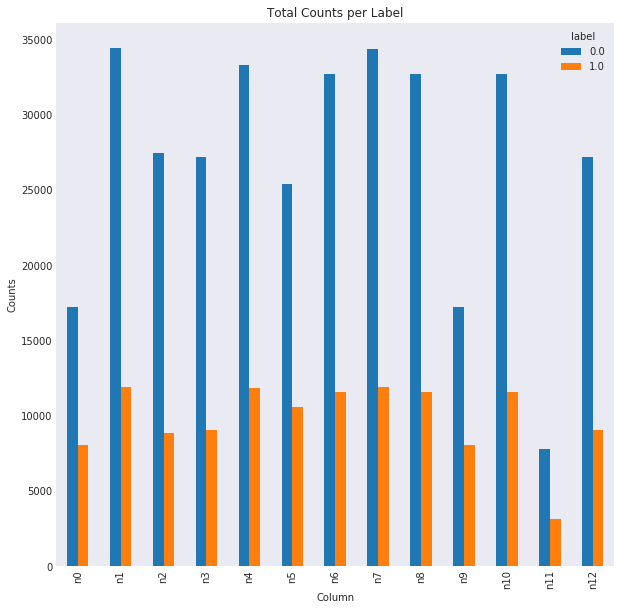

In [18]:
countByLabel = df.groupby(df.columns[0]).count()
countByLabel.iloc[:,:13].transpose().plot(kind='bar', figsize=(10,10))
plt.title('Total Counts per Label')
plt.xlabel('Column')
plt.ylabel('Counts')

We don't see strong evidence for feature selection here. Most columns show roughly 65-75% of non-clicks which is right in line with the population distribution.

Since we have such a large feature space already, we want to determine if we can reduce the number of numerical columns. If certain numerical variables are correlated with each other, we might be able to combine these columns or simply drop one or the other. We will examine a correlation matrix to make this determination

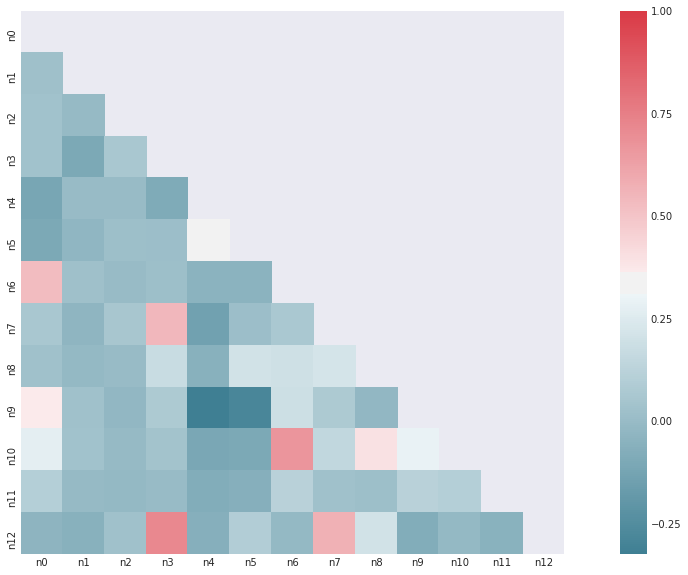

In [19]:
corr = df.iloc[:,1:14].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, square=True)

We see that we have little to no correlation in our numeric variables. It appears that `n6` and `n10` are the most strongly positively correlated, but they only have a correlation coefficient of ~0.6. If we were going to be using this data for inference (as we might if we were designing the ad that we were trying to get clicks on) then we may consider keeping only one of these variables so as to avoid multicollinearity in our model. Since we only care about predictive power, we will leave these variables as they are in our model. 

The last thing we want to look at in our numerical columns is the distribution of values. We saw we had a wide range of values, with relatively small standard deviations in many of the numerical variables and this indicates that we might have considerable skew in our variables. We will examine the histograms each numerical variable

In [20]:
def plotHistograms(df):
    # set up the subplot figure
    dim = np.ceil(np.sqrt(len(df.columns[1:14])))
    fig = plt.figure(figsize=(6,4))
    fig.subplots_adjust(left=0, right=2, bottom=0, top=2.5)
    for i,c in enumerate(df.columns[1:14]):
        # for each numerical variable, plot a histogram of non-missing values
        ax = fig.add_subplot(dim, dim, i + 1)
        ax.hist(df[c].dropna(), bins=50)
        ax.set_title(df.columns[i + 1])

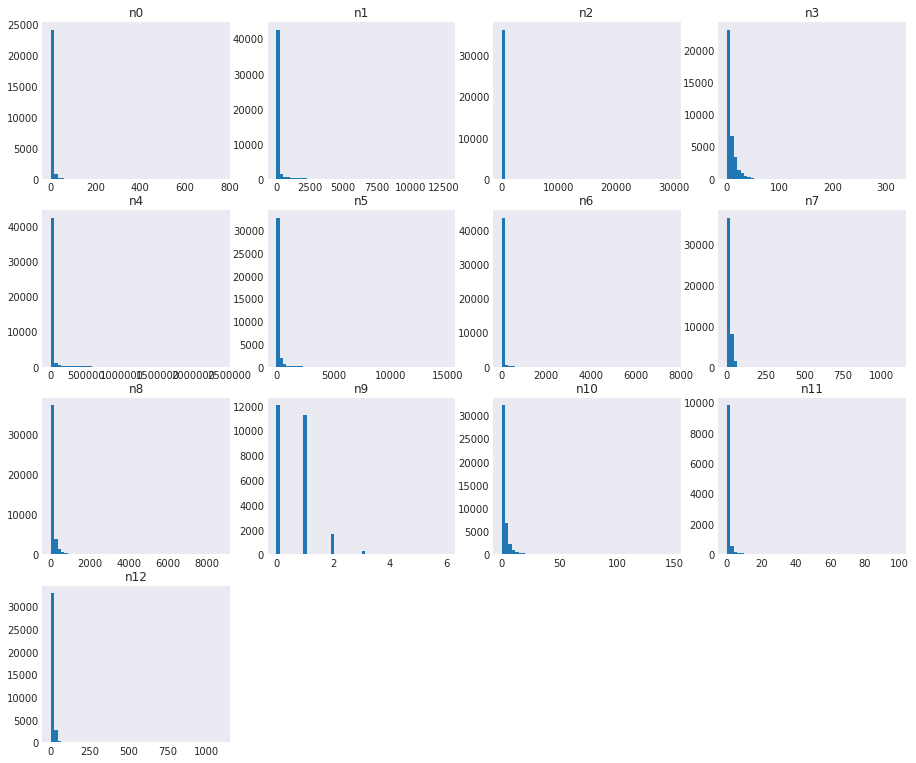

In [21]:
plotHistograms(df)

We see from the histogram that we have pretty extreme skew in all our numeric variables. This indicates we may want to consider applying a log transform to reduce skew and variability in these variables

In [22]:
def plotHistogramsWithLogTransformation(df):
    # set up the subplots figure
    dim = np.ceil(np.sqrt(len(df.columns[1:14])))
    fig = plt.figure(figsize=(6,4))
    fig.subplots_adjust(left=0, right=2, bottom=0, top=2.5)
    for i, col in enumerate(df.columns[1:14]):
        # add the subplot
        ax = fig.add_subplot(dim, dim, i + 1)
        
        # replace the missing values with 0
        c = df[col].copy()
        c.fillna(0, inplace=True)
        
        # take natural log of nonzero values (to avoid -inf)
        c[c != 0] = c[c != 0].apply(np.log)
        
        # plot histogram
        ax.hist(c.dropna(), bins=50)
        ax.set_title(df.columns[i + 1])

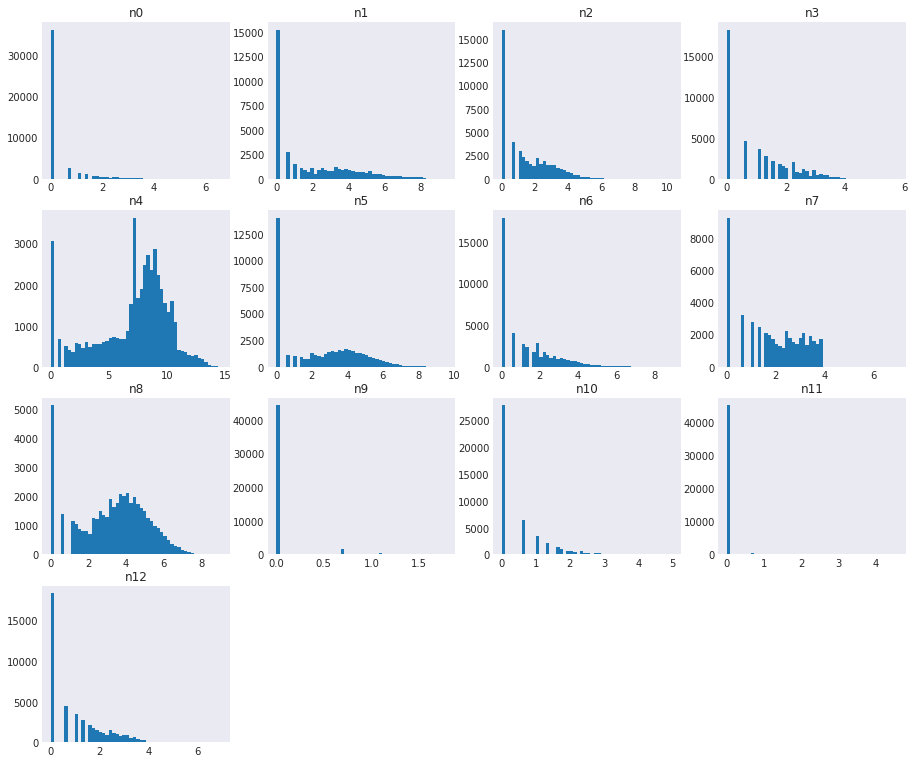

In [23]:
plotHistogramsWithLogTransformation(df)

The log transformation clearly helps to make the distributions more closely approach normality, though each variable does still have a heavy amount of zeros present. We will want to apply a log transformation during our feature engineering phase to help reduce the variability of each parameter

## Examine Categorical variables

We can now start to examine the categorical data. In order to understand the size of our feature space, we need to understand the number of unique values for each categorical variable, since each unique value will become its own feature eventually. Let's look at the total counts, the number of missing values, and the number of distinct values in each category:

In [24]:
categoricalCounts = train[train.columns[14:]].summary('count')

In [25]:
categoricalCounts.show(vertical=True)

-RECORD 0-----------
 summary | count    
 c0      | 45840617 
 c1      | 45840617 
 c2      | 44281144 
 c3      | 44281144 
 c4      | 45840617 
 c5      | 40299992 
 c6      | 45840617 
 c7      | 45840617 
 c8      | 45840617 
 c9      | 45840617 
 c10     | 45840617 
 c11     | 44281144 
 c12     | 45840617 
 c13     | 45840617 
 c14     | 45840617 
 c15     | 44281144 
 c16     | 45840617 
 c17     | 45840617 
 c18     | 25667759 
 c19     | 25667759 
 c20     | 44281144 
 c21     | 10885544 
 c22     | 45840617 
 c23     | 44281144 
 c24     | 25667759 
 c25     | 25667759 



In [26]:
categoricalNulls = {}
for c in categoricalCounts.columns[1:]:
    categoricalNulls[c] = N - int(categoricalCounts.select(c).collect()[0][0])
print('missing categorical values\n')
pprint(categoricalNulls)

missing categorical values

{'c0': 0,
 'c1': 0,
 'c10': 0,
 'c11': 1559473,
 'c12': 0,
 'c13': 0,
 'c14': 0,
 'c15': 1559473,
 'c16': 0,
 'c17': 0,
 'c18': 20172858,
 'c19': 20172858,
 'c2': 1559473,
 'c20': 1559473,
 'c21': 34955073,
 'c22': 0,
 'c23': 1559473,
 'c24': 20172858,
 'c25': 20172858,
 'c3': 1559473,
 'c4': 0,
 'c5': 5540625,
 'c6': 0,
 'c7': 0,
 'c8': 0,
 'c9': 0}


We see that many of our categorical columns are not missing any data, but some are missing huge amounts of data. Since we don't know what the categories mean semantically, we don't know if a missing value accurately represents the absence of a certain indicator, or if it's missing due to a logging failure and it actually should represent one of the existing values. 

Now we want to examine the total number of unique values in each category and our dataset as a whole:

In [27]:
uniqueCounts = {}
for c in train.columns[14:]:
    count = train.agg(F.countDistinct(c).alias('c')).collect()[0]['c']
    uniqueCounts[c] = count

In [28]:
uniqueCounts

{'c0': 1460,
 'c1': 583,
 'c2': 10131226,
 'c3': 2202607,
 'c4': 305,
 'c5': 23,
 'c6': 12517,
 'c7': 633,
 'c8': 3,
 'c9': 93145,
 'c10': 5683,
 'c11': 8351592,
 'c12': 3194,
 'c13': 27,
 'c14': 14992,
 'c15': 5461305,
 'c16': 10,
 'c17': 5652,
 'c18': 2172,
 'c19': 3,
 'c20': 7046546,
 'c21': 17,
 'c22': 15,
 'c23': 286180,
 'c24': 104,
 'c25': 142571}

In [29]:
print('Total Size of Feature Space: ', np.sum(list(uniqueCounts.values())))

Total Size of Feature Space:  33762565


With a dataset that has 45M rows, it doesn't make sense to try to build any model with a feature space of 33M. This is nearly the same size as the number of examples, so we doubt our ability to get fitting estimations of all 33M parameters. Additionally, the computational cost does not justify keeping this many unique features. We will need to perform some form of dimensionality reduction or feature selection. It will also benefit us to represent these variables in an "adjacency-list-like" format so as not to end up with long vectors of mostly zeros. We will take advantage of spark SQL's SparseVector representation.

The important takeaways from this EDA are as follows:
- We want to apply a log transformation to the numerical columns to reduce skew and variability in these variables
- We need to apply standardization to the numerical columns so that each variable exists in the same scale
- Because we have to change the categorical features to sets of indicator features for our chosen algorithms, we will end up with a massive feature space that we need to reduce to manage the computational complexity of the problem
- Even after reducing the feature space, we will want to use a sparse representation of the data to reduce memory usage

We are now ready to apply these concepts during our feature engineering phase and then input our transformed dataset into our machine learning algorithm.

# 4. Algorithm Implementation  

## 4a. Feature Engineering

In addition to transforming and scaling the numerical columns, the main feature engineering challenge with this dataset is how to reduce the number of features from the number that would result if we naively one-hot encoded each categorical variable. We experimented with two distinct solutions to this problem:
- Modulo-based hashing function: We drew inspiration from the writeup of one of the kaggle competition winners, who used a hashing function to reduce the number of categorial variables. For this implementation, we kept all 26 of the initial categorical features, but dropped the infrequent values (any that occurred fewer than 10 times) and then took the variables that still had very large numbers of categories remaining and hashed them to a smaller size (effectively randomly binning multiple values for that feature into a single dummy feature). This methodology is explained in more detail below.
- Random forest feature selection: We also wondered if we could reduce the feature space by completely removing some features which don't have as much impact on the final predictions. We decided to try using feature importances from a random forest model in order to completely eliminate some of the categorical variables from the final training set. This also gave us a good excuse to learn how to use another model in the Spark ML package.

Our best model was one of the ones that we trained using the modulo-based hashing function, so that is the version we describe in detail here. 

### Train/Test Split

While the initial data came with a test set, that set did not have a label, presumably because it was used for Kaggle competition submissions. We need a training set that has a label in order to get evaluation metrics for how well our model generalizes to unseen data, so we will set aside a random sample of the training set as a test set. Since our dataset is so large, we chose to split our training and test set with a 90/10 split, so as to keep as much training data as possible, but still have a good size test set to work with. 

In [32]:
train, test = train.randomSplit([9.0, 1.0])

In [33]:
start = time.time()
print(train.count(), test.count())
print('runtime (min): ', (time.time() - start) / 60)

41252700 4587917
runtime (min):  1.0768669366836547


### Log transform numerical data

From the EDA, we see that a log transform will likely be beneficial. In general, machine learning algorithms have a difficult time dealing with a wide range of values (high variance). To reduce variability in the numerical variables we apply a natural log transform to the numerical columns here.

In [34]:
def logTransformNumeric(df):
    # apply log transformation to each numerical column
    numericalCols = [c for c in df.columns if 'n' in c]
    for i,c in enumerate(numericalCols):
        df = df.withColumn(c, F.log(c))
    
    # fill NA values with 0's
    df = df.na.fill(0, subset=df.columns[1:14])
    
    # cache the dataframe
    df.cache()
    
    return df

In [35]:
train = logTransformNumeric(train)
test = logTransformNumeric(test)

### Normalize numerical data (feature scaling)

While feature scaling isn't strictly necessary for logistic regression, our homegrown function uses gradient descent where feature scaling is important. When we do not perform feature scaling, the contour of our cost function becomes steep and narrow which can either cause divergence during the gradient descent, or may require a very small learning rate causing lengthy training times. By applying feature scaling, the contours of the cost function are now more uniform and therefore we can increase our learning rate and arrive at the global minimum of the cost function much more quickly.

In [36]:
def normalizeNumeric(trainDf, testDf):
    
    # collect max and min values for variable normalization
    numericalCols = [c for c in trainDf.columns if 'n' in c]
    stats = trainDf[numericalCols].describe()
    maxes = np.array(stats[stats['summary'] == 'max'].collect())[0][1:]
    mins = np.array(stats[stats['summary'] == 'min'].collect())[0][1:]
    maxes = [float(m) for m in maxes]
    mins = [float(m) for m in mins]
    
    # normalize each numerical variable to within the range of 0-1
    for i,c in enumerate(numericalCols):
        trainDf = trainDf.withColumn(c, (trainDf[c] - mins[i]) / (maxes[i] - mins[i]))
        testDf = testDf.withColumn(c, (testDf[c] - mins[i]) / (maxes[i] - mins[i]))
    
    # cache the dataframes
    trainDf.cache()
    testDf.cache()
    
    return trainDf, testDf

In [37]:
train, test = normalizeNumeric(train, test)

### Categorical Feature Manipulation

In this section, we take steps to reduce the 30 million features that we would get from naively one-hot-encoding this data. We took inspiration from the method used by one of the Kaggle competition winners: https://www.csie.ntu.edu.tw/~r01922136/kaggle-2014-criteo.pdf. First, we identify any value in each categorical column that occurs fewer than 10 or fewer times, and we replace all of those features with a dummy value of "infreq." This prevents us from making features for categorical values that occur so rarely that they're unlikely to make a measurable difference in our final model. After removing infrequent values, we check whether the number of remaining categorical values for the column is greater than our modulo value (100,000 for our best model). If the number of values is greater, we use a hashing function to reduce the number of values to 100,000 max. We do this by first converting the hexadecimal representation to its decimal equivalent, then getting the 100,000 modulo value of the decimal. This has the effect of randomly combining a small group of features (that share a modulo value) into a single feature. We don't expect there to be any inherent relationship between categorical values that share a modulo value (although if we knew more about our data, it would be good to check and see if there are any patterns, or to use a method for combining variables that relies more on domain knowledge). 

In [38]:
def createFeatureVector(trainDf, testDf, n=10, modulo=100000):
    '''Reduce the categorical feature space and generate a single 
    SparseVector representation of all features, numerical and categorical
    '''
    
    # find the infrequent values
    def findInfrequentValues(c):
        '''collect all values in column c with frequency less than n'''
        counts = trainDf.groupBy(c).count()
        infrequentValues = counts.filter(counts['count'] <= n)
        s = infrequentValues.agg(F.collect_set(c)).collect()[0][0]
        return s

    # replace the infrequent values
    def replaceInfrequentValues(row_value):
        '''group all infrequent values under universal label "infreq"'''
        if row_value in infreq_values:
            return "infreq"
        else:
            return row_value
    
    # create the udf object to replace the infrequent values
    replace_infreq_udf = F.udf(replaceInfrequentValues)

    # create hash function for binning categorical variables
    def hashValues(row):
        if row == "infreq":
            return str(row)
        elif row != None:
            # return integer value of hex label, apply modulo (e.g. modulo 10000 keeps only the last 4 digits)
            return str(int('0x' + row, 16) % modulo)
        else:
            return str(row)

    # create udf object for hashing categorical features 
    hash_udf = F.udf(hashValues)

    # hash all hex strings in both train and test
    categoricalCols = [c for c in trainDf.columns if 'c' in c]
    for c in categoricalCols:
        print("eliminating infreqs/hashing column {}".format(c))
        infreq_values = findInfrequentValues(trainDf[c])
        trainDf = trainDf.withColumn(c, replace_infreq_udf(trainDf[c]))
        testDf = testDf.withColumn(c, replace_infreq_udf(testDf[c]))
        unique_values = trainDf.agg(F.countDistinct(trainDf[c])).collect()[0][0]
        if unique_values > modulo:
            trainDf = trainDf.withColumn(c, hash_udf(trainDf[c]))
            testDf = testDf.withColumn(c, hash_udf(testDf[c]))
  
    # index the hash values into numerical indices
    for c in categoricalCols:
        newCol = c + '_idx'
        indexer = StringIndexer(inputCol=c, outputCol=newCol, handleInvalid='keep')
        f = indexer.fit(trainDf)
        trainDf = f.transform(trainDf)
        testDf = f.transform(testDf)
        
    # One-hot encode the numerical indices
    inputCols = [c for c in trainDf.columns if '_idx' in c]
    outputCols = [c.strip('_idx') + '_OHE' for c in inputCols]
    encoder = OneHotEncoderEstimator(inputCols=inputCols, outputCols=outputCols)
    e = encoder.fit(trainDf)
    trainDf = e.transform(trainDf)
    testDf = e.transform(testDf)

    # assemble all features into single SparseVector column
    cols = [c for c in trainDf.columns if 'n' in c or 'OHE' in c]
    v = VectorAssembler(inputCols=cols, outputCol="features")
    trainDf = v.transform(trainDf)
    testDf = v.transform(testDf)
    
    # cache the dataframes
    trainDf.cache()
    testDf.cache()
    
    return trainDf, testDf

In [39]:
start = time.time()
# create feature vector using modulo 100k
train, test = createFeatureVector(train, test, modulo=100000)
print('runtime (min): ', (time.time() - start) / 60)

eliminating infreqs/hashing column c0
eliminating infreqs/hashing column c1
eliminating infreqs/hashing column c2
eliminating infreqs/hashing column c3
eliminating infreqs/hashing column c4
eliminating infreqs/hashing column c5
eliminating infreqs/hashing column c6
eliminating infreqs/hashing column c7
eliminating infreqs/hashing column c8
eliminating infreqs/hashing column c9
eliminating infreqs/hashing column c10
eliminating infreqs/hashing column c11
eliminating infreqs/hashing column c12
eliminating infreqs/hashing column c13
eliminating infreqs/hashing column c14
eliminating infreqs/hashing column c15
eliminating infreqs/hashing column c16
eliminating infreqs/hashing column c17
eliminating infreqs/hashing column c18
eliminating infreqs/hashing column c19
eliminating infreqs/hashing column c20
eliminating infreqs/hashing column c21
eliminating infreqs/hashing column c22
eliminating infreqs/hashing column c23
eliminating infreqs/hashing column c24
eliminating infreqs/hashing column 

### Label Balancing

We also experimented with rebalancing our data set to account for the imbalance of classes (3 times as many negative examples as positive examples). We did this by adding a column to the dataset which indicates a weight for the example to take on based on its label, then passing this column to the weightCol parameter in Spark LogisticRegression. This did not ultimately improve our accuracy, which makes sense; class imbalance solutions like this one are usually suggested when there is a more dramatic imbalance than the one in our data set. 

In [40]:
def balancesLabelWeights(df):
    '''Create weight column to reduce label bias'''
    
    # determine the weight ratio
    numNegatives = df.filter(df["label"] == 0).count()
    totalSetSize = df.count()
    balancingRatio = (totalSetSize - numNegatives) / totalSetSize
    
    # assign weights to labels
    df = df.withColumn("weightCol", df["label"])
    df = df.replace(0, balancingRatio, subset=['weightCol'])
    df = df.replace(1, 1-balancingRatio, subset=['weightCol'])
    
    # cache the dataframe
    df = df.cache()
    
    return df

In [41]:
trainProcessed = train.select('label','features')
testProcessed = test.select('label','features')

In [43]:
start = time.time()
trainProcessed = balancesLabelWeights(trainProcessed)
print('runtime (min): ', (time.time() - start) / 60)

runtime (min):  17.365208633740743


Below, we see the final form of our data set. We are left with three columns: `label` with the correct label, `weightCol` with the weighting value for the example based on the label, and `features`. `features` is a SparseVector of size 806,981. We see that this particular row has 1s for feature 156, 12535, and so on, and 0s in all other features. One thing to note is that we don't see any numerical data for this particular entry (we know this because the numerical features are the first 13 indices, and because we don't see any values in the vector that take on values other than a 1, which is most likely an indicator rather than a numerical value). This is due to a combination of some of our design choices. First and foremost, we chose to fill missing values in the numerical columns with 0. Secondly, the log function in Spark SQL returns 0 for negative values and 0 for 0. So we have increased the already large number of 0s in the numerical data with these transformations, but since we are using a sparse vector representation, the mathematical impact will be the same as if we ignored these values altogether.

In [45]:
trainProcessed.head()

Row(label=0.0, features=SparseVector(806981, {156: 1.0, 12535: 1.0, 12753: 1.0, 19354: 1.0, 35037: 1.0, 133078: 1.0, 133481: 1.0, 136576: 1.0, 212102: 1.0, 313588: 1.0, 411679: 1.0, 411685: 1.0, 411703: 1.0, 411723: 1.0, 414082: 1.0, 512854: 1.0, 520086: 1.0, 521530: 1.0, 615070: 1.0, 706347: 1.0, 707394: 1.0}), weightCol=0.25621744990348816)

In [48]:
trainProcessed.write.format('parquet').save('gs://w261_desa2/notebooks/data/trainProcessed.parquet')

In [49]:
testProcessed.write.format('parquet').save('gs://w261_desa2/notebooks/data/testProcessed.parquet')

## Random Forest Feature Selection Variation

Our preprocessing steps for the random forest feature selection version were nearly identical to the steps above, except that instead of combining all preprocessed features to create the `features` column, we only included the features that had a feature importance of at least .01 in our random forest model (Details on the random forest model are in the appendix).

In [6]:
rf_model = RandomForestClassificationModel.load('gs://emily-final-proj/notebooks/models/fivePercentFiveTreesModel')

In [7]:
featureImportanceArray = rf_model.featureImportances.toArray()
feature_importance_dict = {}
for idx, val in enumerate(featureImportanceArray):
    feature_importance_dict[[c for c in train.columns if c != "label"][idx]] = val
sorted(feature_importance_dict.items(), key=operator.itemgetter(1), reverse=True)

[('c2', 0.37676062360017537),
 ('c20', 0.09663676151042991),
 ('c14', 0.09136973603905837),
 ('c6', 0.07950226641728707),
 ('c10', 0.04098417073205544),
 ('n6', 0.03929470931942393),
 ('n9', 0.0366045614647021),
 ('c15', 0.03517185701992582),
 ('n0', 0.034813246500632354),
 ('c9', 0.027685971009288546),
 ('n4', 0.02722731973848628),
 ('c12', 0.02442215320084348),
 ('n10', 0.018569556138236104),
 ('n12', 0.01811727495539459),
 ('c3', 0.013937126651480877),
 ('n5', 0.007492989644761523),
 ('c23', 0.007458548346306418),
 ('c11', 0.005480094435187552),
 ('c16', 0.003262407594254),
 ('c17', 0.0031184742638533988),
 ('c1', 0.0027018038206150737),
 ('n3', 0.0026858177952641758),
 ('c25', 0.002172678466385636),
 ('n2', 0.0021079474383590945),
 ('c19', 0.0014545054575211757),
 ('n7', 0.0008669971809227661),
 ('c18', 0.00010040125914873607),
 ('n1', 0.0),
 ('n8', 0.0),
 ('n11', 0.0),
 ('c0', 0.0),
 ('c4', 0.0),
 ('c5', 0.0),
 ('c7', 0.0),
 ('c8', 0.0),
 ('c13', 0.0),
 ('c21', 0.0),
 ('c22', 0.0)

In [8]:
cols_to_use = [col.replace("_indexed", "") for col in feature_importance_dict if feature_importance_dict[col] > .01]

In [9]:
print(cols_to_use)

['n0', 'n4', 'n6', 'n9', 'n10', 'n12', 'c2', 'c3', 'c6', 'c9', 'c10', 'c12', 'c14', 'c15', 'c20']


Using our >.01 decision criteria, we ended up preserving six out of 13 numeric columns and 9 out of 26 original categorical columns, for a total of 527,390 features after our feature reduction and one-hot-encoding steps. 

## 4b Implementation of Homegrown Model

### Factorization machines using gradient descent

Following is the implementation of the homegrown factorization machine model as detailed in the algorithm explanation section(2). The model was run on a small training set of around 4000 records and tested on a dataset of around 400 records. These training and test sets were processed with the same feature engineering as the full dataset. The feautures can be in the form of SparseVector, DenseVector or array.

We also implemented the homegrown version of standard logistic regression with first order independent variables and no interaction terms. The implementation can be found in the appendix.

In [3]:
# initialize learning rate, number of latent factors, mean, standard deviation
learning_rate = 0.01
num_latent_factors = 100
# used for initializing the factorized parameters for interactions
mean = 0
# used for initializing the factorized parameters for interactions
std = 0.01

In [4]:
# initializing the regularization parameters
# techincally these should come from cross validation
reg_bias = 0.01
reg_independent = 0.01
reg_interaction = np.full(num_latent_factors, 0.01)

In [5]:
def prediction_calculation(features, w0, W, V):
    """Performs class prediction calculations for the given set of features and weights"""
    # dot product of independent features and weights
    # appending the bias term as well
    independent_features = np.append([1.0], features)
    independent_weights = np.append([w0], W)
    
    # get combinations of features for the interaction terms with degree 2
    total_interaction = 0.0
    for subset in itertools.combinations(enumerate(features),2):
        index1 = int(subset[0][0])
        index2 = int(subset[1][0])
        feature1 = float(subset[0][1])
        feature2 = float(subset[1][1])
        # dot product of v parameters and features
        total_interaction += np.dot(V[index1],V[index2]) * feature1 * feature2
    product = np.dot(independent_features,independent_weights) + total_interaction
    h_x = 1.0/(1.0+math.exp(-product))
    return h_x

In [9]:
def get_params_features_for_vectors(features, W, V):
    """Handle the SparseVectors, DenseVectors or arrays of parameters and features to return the actual values to be used in the gradient calculations"""
    # unpacking the sparse vector to get the respective weights for the features and using just the values present
    if type(features) == SparseVector:
        W_vec = W[features.indices]
        V_vec = V[features.indices]
        features_vec = features.values
    else:
        W_vec = W
        V_vec = V
        features_vec = features

    return features_vec, W_vec, V_vec

In [6]:
def get_parameter_gradients(data, w0, W, V, num_features, num_latent_factors):
    """Yields gradients for all the model parameters"""
    y = data['label']
    features_vec = data['features']
    features, W_new, V_new = get_params_features_for_vectors(features_vec, W, V)
    h_x = prediction_calculation(features, w0, W_new, V_new)
    # converting the features vector representation to array to get the entire representation
    features_array = features_vec.toArray()
    
    # calculating w0 gradients
    w0_gradient = h_x - y
    yield ('w0', [w0_gradient])
    
    # calculating W gradients
    W_gradient = w0_gradient*features_array
    yield ('W', [W_gradient])
    
    # calculating V gradients
    # calculating the sum part of the differenciation of interaction parameters(xl*sum(vj,f * xj))
    sum_v_features = np.zeros((num_features,num_latent_factors))
    # executing sum(vj,f * xj) where j!= l (for all j features except l) in the expression xl*sum(vj,f * xj)
    for i, feature in enumerate(features_array):
        # if the feature is zero no need to compute the sum, we will have a vector of zeros for it
        if feature != 0:
            # handle the first and last elements
            if i == 0:
                sum_v_features[i] = np.dot(features_array[i+1:],V[i+1:,:])
                continue
            if i == num_features-1:
                sum_v_features[i] = np.dot(features_array[:i],V[:i,:])
                continue
            sum_v_features[i] = np.dot(np.concatenate((features_array[:i], features_array[i+1:])),np.concatenate((V[:i,:], V[i+1:,:])))
    # reshape the feature vector to be able to multiple each feature with it's sum of (vj,f*xj) to compute the expression
    # xl*sum(vj,f * xj) where j!= l (for all j features except l)
    feature_reshape = np.reshape(features_array, (num_features, 1))
    # now multiply to get the entire V at once
    differenciation_interaction = np.multiply(feature_reshape,sum_v_features)
    V_gradient = w0_gradient*differenciation_interaction
    yield ('V', [V_gradient])

In [7]:
def get_log_sigmoid(data, w0, W, V):
    """Calculate the log of the prediction, used for calculating the loss"""
    y = data['label']
    features, W, V = get_params_features_for_vectors(data['features'], W, V)
    h_x = prediction_calculation(features, w0, W, V)
    
    if int(y) == 1:
        yield -np.log(h_x)
    else:
        yield -np.log(1-h_x)

In [8]:
def get_log_loss(data_rdd, w0, W, V):
    """Calculating the log loss"""
    loss = data_rdd.flatMap(lambda data: get_log_sigmoid(data, w0, W, V))\
                   .mean()
    
    return loss

In [15]:
def fm_gd(train_rdd, validation_rdd, learning_rate, num_latent_factors, mean, std, reg_bias, reg_independent, reg_interaction, num_steps=10):    
    """Factorization machine model using gradient descent"""
    
    num_features = train_rdd.take(1)[0]['features'].size 
    print('num_features:',num_features)
    
    # initialize the model parameters
    w0 = 0.0
    W = np.zeros(num_features)
    V = np.random.normal(mean, std, (num_features,num_latent_factors))
    
    num_features_b = sc.broadcast(num_features)
    num_latent_factors_b = sc.broadcast(num_latent_factors)
    
    # initialize lists to track model performance
    train_history, validation_history = [], []
    
    for i in range(num_steps):
        # broadcast the model parameters
        w0_b = sc.broadcast(w0)
        W_b = sc.broadcast(W)
        V_b = sc.broadcast(V)

        # calculate all gradients for w0, W and V
        all_gradients_rdd = train_rdd.flatMap(lambda x: get_parameter_gradients(x, w0_b.value, W_b.value, V_b.value, num_features_b.value, num_latent_factors_b.value))\
                                     .cache()
        # perform w0 updates
        w0_gradient = all_gradients_rdd.filter(lambda x: x[0] == 'w0')\
                                       .flatMap(lambda x: x[1])\
                                       .mean()
        w0 -= learning_rate * (w0_gradient + 2 * reg_bias * w0)
        
        # perform W updates
        W_gradient = all_gradients_rdd.filter(lambda x: x[0] == 'W')\
                                       .flatMap(lambda x: x[1])\
                                       .mean()
        W -= learning_rate * (W_gradient + 2 * reg_independent * W)
        
        # perform V updates
        V_gradient = all_gradients_rdd.filter(lambda x: x[0] == 'V')\
                                       .flatMap(lambda x: x[1])\
                                       .mean()
        V -= learning_rate * (V_gradient + 2 * np.multiply(reg_interaction, V))
        
        # find train and validation loss at each iteration
        training_loss = get_log_loss(train_rdd, w0, W, V)
        validation_loss = get_log_loss(validation_rdd, w0, W, V)
        
        # keep track of validation/train loss for plotting
        train_history.append(training_loss)
        validation_history.append(validation_loss)
        
        
    return w0, W, V, train_history, validation_history


In [11]:
# train set
train_df = spark.read.parquet('gs://w261_desa2/notebooks/data/toySampleTrain.parquet')

In [12]:
# train, validation split set
train_df, validation_df = train_df.randomSplit([.9, .1], 10)
train_df = train_df.cache()
validation_df = validation_df.cache()

In [13]:
# create rdd from df
train_rdd = train_df.rdd.cache()
validation_rdd = validation_df.rdd.cache()

In [113]:
start = time.time()
w0, W, V, train_loss, validation_loss = fm_gd(train_rdd, validation_rdd, learning_rate, num_latent_factors, mean, std, reg_bias, reg_independent, reg_interaction, 10)
print(f'... completed job in {time.time() - start} seconds.')

num_features: 24086
... completed job in 2766.5750439167023 seconds.


In [16]:
# predict
def predict_classes(data, w0, W, V):
    features_vec = data['features']
    features, W, V = get_params_features_for_vectors(features_vec, W, V)
    h_x = prediction_calculation(features, w0, W, V)
    if h_x >= 0.5:
        if int(data['label']) == 1:
            yield ('correct', 1)
        else:
            yield ('wrong', 1)
    else:
        if int(data['label']) == 0:
            yield ('correct', 1)
        else:
            yield ('wrong', 1)

In [4]:
# test set
test_df = spark.read.parquet('gs://w261_desa2/notebooks/data/toySampleTest.parquet')
test_rdd = test_df.rdd.cache()

In [108]:
# get the predicted classes for the test set
result = test_rdd.flatMap(lambda x: predict_classes(x, w0, W, V)).reduceByKey(lambda x,y: x + y).collect()

In [116]:
result

[('correct', 301), ('wrong', 126)]

In [119]:
accuracy = result[0][1]/(result[1][1]+result[0][1])
accuracy

0.7049180327868853

Test accuracy of 0.704 was achieved by training the homegrown factorization machine model for 10 iterations.

In [26]:
# plot error curves
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of log loss) , testLoss (list of log loss)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Log Loss error')
    if title:
        plt.title(title)
    plt.show()

**Following is a plot of training and validation loss during training on a small dataset of 849 records over 200 iterations**

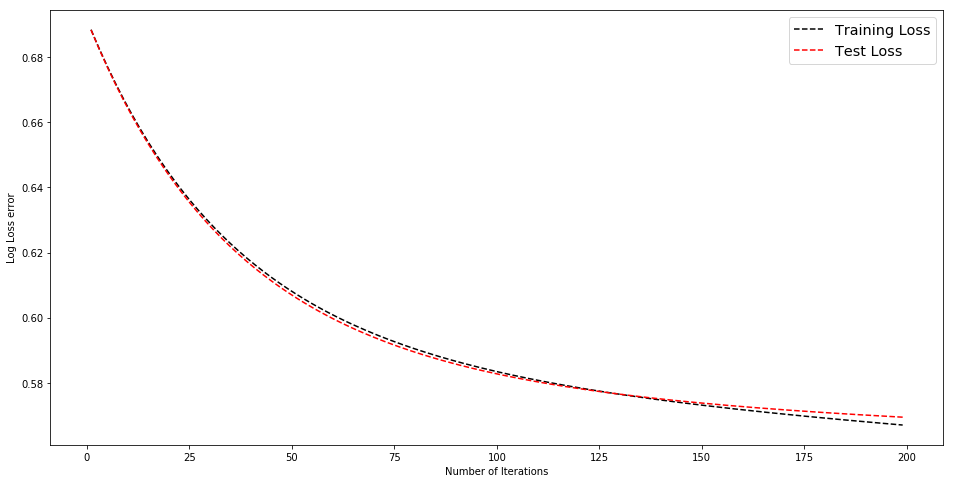

In [17]:
plotErrorCurves(train_loss, validation_loss)

## 4c Logistic Regression with Spark ML

We now want to run the full dataset through a logistic regression model in Spark ML. We want to do this with and without the weight being applied to see if label balancing improves the performance

In [13]:
train = spark.read.parquet('gs://w261_desa2/notebooks/data/trainProcessed.parquet')
test = spark.read.parquet('gs://w261_desa2/notebooks/data/testProcessed.parquet')

In [4]:
MAXITER = 30

In [50]:
print('ACCURACY TO BEAT (guessing 0 every time): \n{:.2f}%'.format(test.filter(test['label'] == 0).count() / test.count() * 100))

ACCURACY TO BEAT (guessing 0 every time): 
74.37%


### Model 1a --> modulo-based hashing with label balancing

In [5]:
# with column weights
lr = LogisticRegression(
    featuresCol='features', 
    labelCol='label', 
    weightCol='weightCol',
    family='binomial',
    standardization=False,
    maxIter=MAXITER
)

In [6]:
start = time.time()
model = lr.fit(train)
print('runtime (min): ', (time.time() - start) / 60)

runtime (min):  17.000190377235413


In [7]:
trainingSummary = model.summary
history = trainingSummary.objectiveHistory

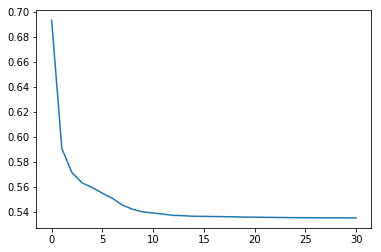

In [8]:
plt.plot(history)

In [ ]:
print('MODEL METRICS ON TRAIN SET WITH LABEL WEIGHTS:\n')
print('Accuracy: ', trainingSummary.accuracy)
print('F-score per label: ', trainingSummary.fMeasureByLabel())
print('Precision per label: ', trainingSummary.precisionByLabel)
print('Recall per label: ', trainingSummary.recallByLabel)

MODEL METRICS ON TRAIN SET WITH LABEL WEIGHTS:

Accuracy:  0.7266794415880657
F-sore per label:  [0.797699258330019, 0.5788196060417692]
Precision per label:  [0.887353030367926, 0.47822492671831046]
Recall per label:  [0.7244994123463263, 0.7330079239998403]


In [55]:
testSummary = model.evaluate(test)

In [56]:
print('MODEL METRICS ON TEST SET WITH LABEL WEIGHTS:\n')
print('Accuracy: ', testSummary.accuracy)
print('F-score per label: ', testSummary.fMeasureByLabel())
print('Precision per label: ', testSummary.precisionByLabel)
print('Recall per label: ', testSummary.recallByLabel)

MODEL METRICS ON TEST SET WITH LABEL WEIGHTS:

Accuracy:  0.713027938386854
F-sore per label:  [0.7876523250435307, 0.5575341627890252]
Precision per label:  [0.8758019387486833, 0.46087741620041894]
Recall per label:  [0.7156245887845784, 0.7054923726968402]


In [18]:
predictions = model.transform(test)
predCounts = predictions.groupBy('prediction').count().collect()
N = predictions.count()
print("{:.2f}% predicted non-clicks, {:.2f}% predicted clicks".format((predCounts[0]['count'] / N) * 100, (predCounts[1]['count'] / N) * 100))

60.77% predicted clicks, 39.23% predicted non-clicks


In [20]:
model.save('gs://w261_desa2/notebooks/models/sparkLRModel_withColWeight')

### Model 1b --> modulo-based hashing without label balancing

In [21]:
lr = LogisticRegression(
    featuresCol='features', 
    labelCol='label', 
#     weightCol='weightCol',
    family='binomial',
    standardization=False,
    maxIter=MAXITER
)

In [22]:
start = time.time()
model = lr.fit(train)
print('runtime (min): ', (time.time() - start) / 60)

runtime (min):  11.495596583684286


In [23]:
trainingSummary = model.summary
history = trainingSummary.objectiveHistory

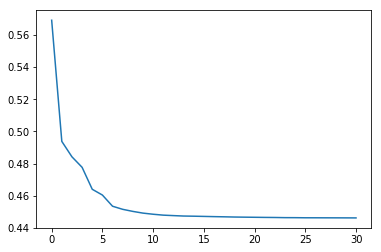

In [24]:
plt.plot(history)

In [20]:
print('MODEL METRICS ON TRAIN SET WITHOUT LABEL WEIGHTS:\n')
print('Accuracy: ', trainingSummary.accuracy)
print('F-score per label: ', trainingSummary.fMeasureByLabel())
print('Precision per label: ', trainingSummary.precisionByLabel)
print('Recall per label: ', trainingSummary.recallByLabel)

MODEL METRICS ON TRAIN SET WITHOUT LABEL WEIGHTS:

Accuracy:  0.7923913586262232
F-sore per label:  [0.8698069127126281, 0.4878652273294674]
Precision per label:  [0.8150855740016201, 0.662940272987901]
Recall per label:  [0.9324045422099337, 0.38594223732036087]


In [52]:
testSummary = model.evaluate(test)

In [53]:
print('MODEL METRICS ON TEST SET WITHOUT LABEL WEIGHTS:\n')
print('Accuracy: ', testSummary.accuracy)
print('F-score per label: ', testSummary.fMeasureByLabel())
print('Precision per label: ', testSummary.precisionByLabel)
print('Recall per label: ', testSummary.recallByLabel)

MODEL METRICS ON TEST SET WITHOUT LABEL WEIGHTS:

Accuracy:  0.7822519457086953
F-sore per label:  [0.8634195945940403, 0.4632983558505803]
Precision per label:  [0.809193028223063, 0.6289111042397157]
Recall per label:  [0.9254359652781055, 0.3667271657186403]


In [32]:
predictions = model.transform(test)
predCounts = predictions.groupBy('prediction').count().collect()
print("{:.2f}% predicted non-clicks, {:.2f}% predicted clicks".format((predCounts[0]['count'] / N) * 100, (predCounts[1]['count'] / N) * 100))

85.06% predicted non-clicks, 14.94% predicted clicks


In [31]:
model.save('gs://w261_desa2/notebooks/models/sparkLRModel_noColWeight')

### Model 2--> random forest feature selection approach

Interestingly, though our random forest feature selection model did not beat our best model's test accuracy, it came pretty close with far fewer features:

In [20]:
lr = LogisticRegression(
    featuresCol='features', 
    labelCol='label', 
    #regParam=0.01, 
    family='binomial',
    standardization=False,
    maxIter=MAXITER)

In [21]:
start = time.time()
model = lr.fit(train)
print('runtime (min): ', (time.time() - start) / 60)

runtime (min):  36.008772536118826


In [22]:
trainingSummary = model.summary
history = trainingSummary.objectiveHistory

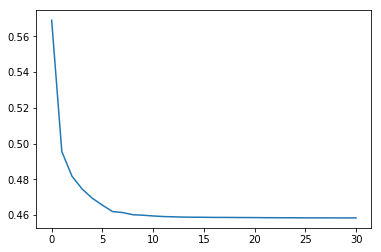

In [23]:
plt.plot(history)

In [24]:
trainingSummary.accuracy

0.7862077935147408

In [25]:
testSummary = model.evaluate(test)

In [28]:
print('MODEL METRICS ON RANDOM FOREST FEATURE SELECTION METHOD:\n')
print('Accuracy: ', testSummary.accuracy)
print('F-score per label: ', testSummary.fMeasureByLabel())
print('Precision per label: ', testSummary.precisionByLabel)
print('Recall per label: ', testSummary.recallByLabel)

MODEL METRICS ON RANDOM FOREST FEATURE SELECTION METHOD:

Accuracy:  0.7794698710628699
F-score per label:  [0.8626136903706717, 0.4414375078068953]
Precision per label:  [0.8035712883632612, 0.6294762062388676]
Recall per label:  [0.9310204173859865, 0.3399013352762136]


## Algorithm Implementation Conclusions

We tested our full dataset under a variety of conditions using different feature engineering methods to address the two distinct feature engineering solutions we considered in section **4a**. We experimented with a variety of techniques on a sample set including different modulo values, applying or not applying a log transform, grouping infrequent categorical features, and adding a label weight to address label bias. We experimented with hyperparameter tuning by tuning on a sample and applying the optimized hyperparameters to the full training set.  Doing so resulted in a slight increase of the accuracy from 0.7822519457086953 to 0.7823707360006731.  The optimal hyperparameters were $\lambda = 0.001$ and $\alpha = 0.0$; see Appendix for details. The three models shown in this section represent the performance of our two distinct feature engineering solutions. Models 1a and 1b represent the modulo-based hashing solution (with and without label balancing) and the model 2 represents the random forest feature selection.

We clearly see the effect that adding in label weights has on models 1a and 1b when we look at the percentage of predicted clicks. The true percentage of clicks is roughly ~26%. We see that when we weight the labels based on population proportion we have actually weighted them too strongly and we end up over-predicting clicks at ~40%. If we remove the label weights, we end up under-predicting clicks at ~15%, yet our accuracy improves somewhat drastically. A good path for future exploration would be to attempt find a label weight middle ground which would balance the over/under predicting of clicks with the actual population proportion.

Our three best performing models are shown above and represent the modulo-based hashing trick (1a, 1b), and the random forest feature selection (2). While the best model we trained from a performance perspective was the modulo-based hashing function with no label balancing we could argue that the parsimony of the random forest feature selection model is better, since it achieves a similar accuracy to the other models with about 65% of the features. If we had had more time, we might have tried more variations on this strategy - for instance, experimenting with the feature importance threshold we used to add features to the model, changing the preprocessing on the remaining features to preserve more of the raw data, or trying interaction terms. 

While overall we achieved similar performance results from both feature engineering techniques, from a scalability standpoint, the modulo-based hashing trick is the superior methodology. The massive feature space of this dataset causes the random forest feature selection to be a very expensive task even on a small sample of the full data, due to the large number of branches being created. Therefore, modulo-based hashing would likely be the method of feature engineering to move forward with for future exploration.

# 5. Application of Course Concepts 

**Bias/Variance Tradeoff**  
While our group built our collective understanding of factorization machines, we discussed the selection of k, the number of latent features that the model will learn per data feature. We determined that we could use the bias/variance tradeoff in our process of understanding and selecting a value for k. A smaller value of k increases our model’s bias and decreases its’ variance; a smaller k means less ability to model complex patterns in the data, and with that, a greater likelihood of errors due to the model not capturing the true patterns in the data. A larger k means a much more flexible model that can learn more nuanced patterns, but also greater sensitivity to the specific data we train on. As a result, a model with a larger k will be sensitive to the particular sample of data we train on, and will be more likely to make errors from overfitting to patterns in the training set that don’t generalize to the problem in general. A larger k means adding more parameters to the model. We set k to 100 in the version of the factorization machine that we ran, which gave us 100 parameters per feature, in addition to the regular coefficient on each feature and the bias term. We can make similar observations about the bias/variance tradeoff as we change the number of features in our logistic regression model - the more features we have, the more errors come from the model's sensitivity to nuances in the training set (variances), whereas the fewer features we have, the more errors come from the model's inability to capture nuanced patterns (bias). 

**Sparse Data Representations**  
Spark’s SparseVector data type is an extremely helpful feature that helps us represent feature-rich data sets in a compact way. When we use one-hot encoding to turn our categorical features into a set of dummy features, we end up with a vector that is as long as the number of separate categorical values we have. In this case, depending what kind of preprocessing we do, that means a vector that is anywhere from hundreds of thousands to millions of indices long. However, since only 39 of the new features should have a value in them, these new feature vectors are extremely sparse, with the vast majority of their entries being 0s. The SparseVector data type takes advantage of this sparsity; instead of storing the full vector of hundreds of thousands of 0s, it only stores the overall vector size and the indices of the non-zero elements. It’s a similar idea to the adjacency lists vs matrices we looked at for representing graphs earlier in the term; the sparse vector, like the adjacency list, only stores the data that has non-zero values, which allows for a compressed data representation that nonetheless conveys all the information needed for downstream operations. Spark’s OneHotEncoderEstimator method returns a SparseVector, as does the VectorAssembler and the LogisticRegression estimator we used was able to take in the SparseVector as input features; if we had had to use a denser representation of these features, the size of the data would have been far larger when we wrote it to parquet, and it would also take up more memory when running the logistic regression estimator on it.

**Batch vs Stochastic Gradient Descent**  
All of our homegrown models in this project were trained using gradient descent, where the model makes a series of updates to the parameter values, each time determining the size and direction of update to make by using the partial derivative of the cost function (in combination with the learning rate and a regularization term). Batch and stochastic gradient descent are two different methods for determining when to make the updates in the algorithm, and the choice comes with different tradeoffs. Stochastic gradient descent is generally preferred to batch since it usually converges faster. When updating the gradient based on just one example at a time, instead of waiting to get through all training examples to start updating, the model will converge faster, since it can start making updates and getting in the right neighborhood very quickly. The fluctuating nature of SGD might prevent it from getting to the true minimum as well as batch GD would, but it can get an approximation of the minimum much faster, and often that is good enough. From a scalability perspective, it is good that SGD converges faster, but also, it can’t be parallelized, since the training the model on row 2 requires that we have already run the model and performed the gradient update from row 1. Our homegrown implementation of logistic regression used batch gradient descent in order to take full advantage of the parallelization built into spark. Spark’s LogisticRegression implementation in the ML package uses L-BFGS, a different numerical optimization method that typically converges faster than gradient descent does. 

**Distributed Computing**  
The homegrown factorization machine model with batch gradient descent implementation takes advantage of Spark's distributed computing framework (which is based on functional programming principles) and broadcasting. The implementation is an iterative process for which Spark works better than Hadoop, because in Hadoop the data at each iteration will have to be written to a file and read back in for use by the next iteration, and file i/o is time consuming.  Computing parameter gradients with respect to loss function is embarrassingly parallel. Each training example can be sent to a mapper to compute the partial gradients of the loss in parallel, since there is no communication required between the different tasks. The partial gradients can later be aggregated to calculate the mean. The model parameters are broadcasted to the worker nodes instead of passed as parameters to the function that calculates the gradients at every iteration. Passing as parameters is inefficient because that would result in maintaining model parameter copies for every record in the data being sent to a worker, and the number of records can be huge, especially with the interaction term factorized parameters.

# 6. Appendix

## Random Forest for Feature Selection

This was the code used to train a random forest and use the feature importances from that model to choose what features to include in a logistic regression model. This was very computationally expensive due to the number of potential splits in the categorical features, so we used a sample of the data (5%) and did the modulo hashing trick to the categorical features before running the random forest. Optimally, we would have used more data and done minimal preprocessing on the input features to get a less biased view of feature importance. 

In [ ]:
# vector assembler won't work if any values are null
train = train.na.fill(0, subset=train.columns[1:14])
test = test.na.fill(0, subset=test.columns[1:14])

In [ ]:
# do the infrequent value dropping and modulo steps from the regular createFeatureVector process
# (we will string index these features, but we won't need to one hot encode them)
def createFeatureVectorForRF(trainDf, testDf, n=10, modulo=10000):
    '''Reduce the categorical feature space for RF
    '''
    
    # find the infrequent values
    def findInfrequentValues(c):
        '''collect all values in column c with frequency less than n'''
        counts = trainDf.groupBy(c).count()
        infrequentValues = counts.filter(counts['count'] <= n)
        s = infrequentValues.agg(F.collect_set(c)).collect()[0][0]
        return s

    # replace the infrequent values
    def replaceInfrequentValues(row_value):
        '''group all infrequent values under universal label "infreq"'''
        if row_value in infreq_values:
            return "infreq"
        else:
            return row_value
    
    # create the udf object to replace the infrequent values
    replace_infreq_udf = F.udf(replaceInfrequentValues)

    # create hash function for binning categorical variables
    def hashValues(row):
        if row == "infreq":
            return str(row)
        elif row != None:
            # return integer value of hex label, apply modulo (e.g. modulo 10000 keeps only the last 4 digits)
            return str(int('0x' + row, 16) % modulo)
        else:
            return str(row)

    # create udf object for hashing categorical features 
    hash_udf = F.udf(hashValues)

    # hash all hex strings in both train and test
    categoricalCols = [c for c in trainDf.columns if 'c' in c]
    for c in categoricalCols:
        print("eliminating infreqs/hashing column {}".format(c))
        infreq_values = findInfrequentValues(trainDf[c])
        trainDf = trainDf.withColumn(c, replace_infreq_udf(trainDf[c]))
        testDf = testDf.withColumn(c, replace_infreq_udf(testDf[c]))
        unique_values = trainDf.agg(F.countDistinct(trainDf[c])).collect()[0][0]
        if unique_values > modulo:
            trainDf = trainDf.withColumn(c, hash_udf(trainDf[c]))
            testDf = testDf.withColumn(c, hash_udf(testDf[c]))
    return trainDf, testDf

train, test = createFeatureVectorForRF(train, test)
categorical_cols = [c for c in train.columns if 'c' in c or 'label' in c]
indexed_cols = []
for col in categorical_cols:
    new_col_name = "{}_indexed".format(col)
    vec_indexer = StringIndexer(inputCol=col, outputCol=new_col_name, handleInvalid='keep').fit(train)
    train = vec_indexer.transform(train)
    test = vec_indexer.transform(test)
    indexed_cols.append(new_col_name)

In [ ]:
cols_for_features = [c for c in train.columns if 'n' in c and c!="label_indexed"]
print(cols_for_features)
assembler = VectorAssembler(inputCols=cols_for_features, outputCol="features")
newTrain = assembler.transform(train)
newTest = assembler.transform(test)

In [ ]:
# Train a RandomForest model.
start_time = time.time()
rf = RandomForestClassifier(labelCol="label_indexed", featuresCol="features", numTrees=5, maxBins=100000)
fit_rf = rf.fit(newTrain)
end_time = time.time()
print("Total time taken = {}".format(end_time - start_time))

### Hyperparameter Tuning

In [237]:
def metricsCalc(lp):
    '''
    Calculate binary classification metrics
    '''
    
    trueP = lp.filter(lp["prediction"] == 1.0).filter(lp["label"] == lp["prediction"]).count()
    trueN = lp.filter(lp["prediction"] == 0.0).filter(lp["label"] == lp["prediction"]).count()
    falseP = lp.filter(lp["prediction"] == 1.0).filter(lp["label"] != lp["prediction"]).count()
    falseN = lp.filter(lp["prediction"] == 0.0).filter(lp["label"] != lp["prediction"]).count()

    # Calculate precision, recall, accuracy, and F1
    precision = float(trueP)/(trueP + falseP) # aka specificity
    recall = float(trueP)/(trueP + falseN)  # aka sensitivity
    accuracy = float(trueP + trueN)/(trueP + trueN + falseP + falseN)
    if trueP != 0:
        f1 = 2 * (precision * recall) / (precision + recall)  # if trueP=0, then precision=0 and recall=0, so f1 doesn't work.
    else:
        f1 = 'TP=0 so cannot calc f1'

    # prints
    print('Number of records:', (trueP+falseP+trueN+falseN))
    print(f'trueP\t\t{trueP}')
    print(f'trueN\t\t{trueN}')
    print(f'falseP\t\t{falseP}')
    print(f'falseN\t\t{falseN}')
    print(f'accuracy\t{accuracy}')
    print(f'precision\t{precision}')
    print(f'recall\t\t{recall}')
    print(f'f1\t\t{f1}')

In [153]:
# Logisitic Regression with Regularization and Cross Validation for Hyperparameter Tuning

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

lr_small_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_small_reg.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr_small_reg.elasticNetParam, [0.5, 0.7, 0.9]) \
    .build()

crossval_lr_small = CrossValidator(estimator=lr_small_reg,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=5)

#fit model to training data
lr_small_reg_model = crossval_lr_small.fit(small_sample_train)

#Transform test data
lr_small_reg_result = lr_small_reg_model.transform(small_sample_test)

#view id, label, prediction and probability from result of modeling
lr_small_reg_result.select('label', 'prediction', 'probability').show(10)


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.75004694775605...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.82726170576101...|
|  0.0|       0.0|[0.81700622602457...|
|  0.0|       0.0|[0.81700622602457...|
|  0.0|       0.0|[0.76224960882026...|
|  0.0|       0.0|[0.76224960882026...|
+-----+----------+--------------------+
only showing top 10 rows



In [167]:
print('Best Hyperparameters for Small Sample dataset')
print("best regParam:", lr_small_reg_model.bestModel.regParam)
print("best elasticNetParam:", lr_small_reg_model.bestModel.elasticNetParam)

Best Hyperparameters for Small Sample dataset
best regParam: LogisticRegression_4542b0fd3fd28f383cc3__regParam
best elasticNetParam: LogisticRegression_4542b0fd3fd28f383cc3__elasticNetParam


In [175]:
lr_small_reg_model.getEstimatorParamMaps()[ np.argmax(lr_small_reg_model.avgMetrics) ]

{Param(parent='LogisticRegression_4542b0fd3fd28f383cc3', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
 Param(parent='LogisticRegression_4542b0fd3fd28f383cc3', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.9}

#### Best hyperparameters for small sample: regParam = 0.01; elasticNetParam = 0.9.

In [217]:
print('intercept:', lr_small_reg_model.bestModel.intercept)
print('coefficients:', lr_small_reg_model.bestModel.coefficients)

intercept: -1.2090852455788703
coefficients: [2.478052796049695,0.06401468125312675,-0.6580943688652904,0.04402230673054404,-0.3572683651957661,0.0,0.07014881268525996,0.0,-0.48191783947288547]


In [156]:
lp_reg = lr_small_reg_result.select( "label", "prediction")
metricsCalc(lp_reg)

Number of records: 10365
trueP		56
trueN		7641
falseP		44
falseN		2624
accuracy	0.7425952725518572
precision	0.56
recall		0.020895522388059702
f1		0.040287769784172665


### Logistic Regression with first order independent variables and no interaction terms

In [35]:
def prediction_calculation_independent(features, w0, W):
    """Performs class prediction calculations for the given set of features and weights"""
    # dot product of independent features and weights
    # appending the bias term as well
    independent_features = np.append([1.0], features)
    independent_weights = np.append([w0], W)
    
    product = np.dot(independent_features,independent_weights)
    h_x = 1.0/(1.0+math.exp(-product))
    return h_x

In [36]:
def get_parameter_gradients_independent(data, w0, W):
    """Yields gradients for all the model parameters"""
    y = data['label']
    features_vec = data['features']
    features, W_condensed = get_params_features_for_vectors_independent(features_vec, W)
    h_x = prediction_calculation_independent(features, w0, W_condensed)
    # converting the features vector representation to array to get the entire representation
    features_array = features_vec.toArray()
    augmented_features = np.append([1.0], features_array)
    
    # calculating W gradients
    gradients = (h_x - y)*augmented_features
    yield gradients

In [37]:
def get_log_loss_independent(data_rdd, w0, W):
    """Calculating the log loss"""
    # calculation the log loss
    loss = data_rdd.flatMap(lambda data: get_log_sigmoid_independent(data, w0, W))\
                   .mean()
    
    return loss

In [38]:
def get_log_sigmoid_independent(data, w0, W):
    """Calculate the log of the prediction, used for calculating the loss"""
    y = data['label']
    features, W = get_params_features_for_vectors_independent(data['features'], W)
    h_x = prediction_calculation_independent(features, w0, W)
   
    if int(y) == 1:
        yield -np.log(h_x)
    else:
        yield -np.log(1-h_x)

In [39]:
def get_params_features_for_vectors_independent(features, W):
    """Handle the SparseVectors, DenseVectors or arrays of parameters and features to return the actual values to be used in the gradient calculations"""
    # unpacking the sparse vector to get the respective weights for the features and using just the values present
    if type(features) == SparseVector:
        W_vec = W[features.indices]
        features_vec = features.values
    else:
        W_vec = W
        features_vec = features

    return features_vec, W_vec

In [41]:
def logistic_gd(train_rdd, validation_rdd, learning_rate=0.1, reg_type='ridge', reg_param=0.01, num_steps=20):    
    """Logistic regression model using gradient descent"""
    
    num_features = train_rdd.take(1)[0]['features'].size 
    print('num_features:',num_features)
    
    # initialize the model parameters
    w0 = 0.0
    W = np.zeros(num_features)
    
    # initialize lists to track model performance
    train_history, validation_history = [], []
    
    for i in range(num_steps):
        # broadcast the model parameters
        w0_b = sc.broadcast(w0)
        W_b = sc.broadcast(W)

        # calculate all gradients for w0, W and V
        gradients = train_rdd.flatMap(lambda x: get_parameter_gradients_independent(x,w0_b.value,W_b.value))\
                             .mean()
        
        if reg_type == 'ridge':
             gradient_penalty = gradients[1:] + 2 * reg_param * W
        if reg_type == 'lasso':
             gradient_penalty = gradients[1:] + reg_param * np.sign(W)

        w0 = w0 - learning_rate * gradients[0]
        if reg_type == 'ridge' or reg_type == 'lasso':
            W = W - learning_rate * gradient_penalty
        else:
            W = W - learning_rate * gradients[1:]
        
        # find train and validation loss at each iteration
        training_loss = get_log_loss_independent(train_rdd, w0, W)
        validation_loss = get_log_loss_independent(validation_rdd, w0, W)
        
        # keep track of validation/train loss for plotting
        train_history.append(training_loss)
        validation_history.append(validation_loss)
        
        
    return w0, W, train_history, validation_history


In [42]:
# train set
train_df = spark.read.parquet('dac/toy/toySampleTrain.parquet')
train_df, train_small_df, validation_df = train_df.randomSplit([.7, .2, .1], 10)
train_df = train_df.cache()
train_small_df = train_small_df.cache()
validation_df = validation_df.cache()

In [43]:
# create rdd from df
train_rdd = train_df.rdd.cache()
train_small_rdd = train_small_df.rdd.cache()
validation_rdd = validation_df.rdd.cache()

In [44]:
start = time.time()
w0_l, W_l, train_loss_l, validation_loss_l = logistic_gd(train_small_rdd, validation_rdd, num_steps=5)
print(f'... completed job in {time.time() - start} seconds.')

num_features: 24086
... completed job in 4.83094048500061 seconds.


In [51]:
# predict
def predict_classes_independent(data, w0, W):
    features_vec = data['features']
    features, W_condensed = get_params_features_for_vectors_independent(features_vec, W)
    h_x = prediction_calculation_independent(features, w0, W_condensed)
    
    if h_x >= 0.5:
        if int(data['label']) == 1:
            yield ('correct', 1)
        else:
            yield ('wrong', 1)
    else:
        if int(data['label']) == 0:
            yield ('correct', 1)
        else:
            yield ('wrong', 1)

In [52]:
# test set
test_df = spark.read.parquet('dac/toy/toySampleTest.parquet')
test_rdd = test_df.rdd.cache()

In [53]:
# get the predicted classes for the test set
result = test_rdd.flatMap(lambda x: predict_classes_independent(x, w0_l, W_l)).reduceByKey(lambda x,y: x + y).collect()

In [54]:
result

[('wrong', 126), ('correct', 301)]

In [55]:
accuracy = result[1][1]/(result[1][1]+result[0][1])
accuracy

0.7049180327868853

#### Following is a plot of training and validation loss during training on a small dataset of 826 records over 100 iterations 

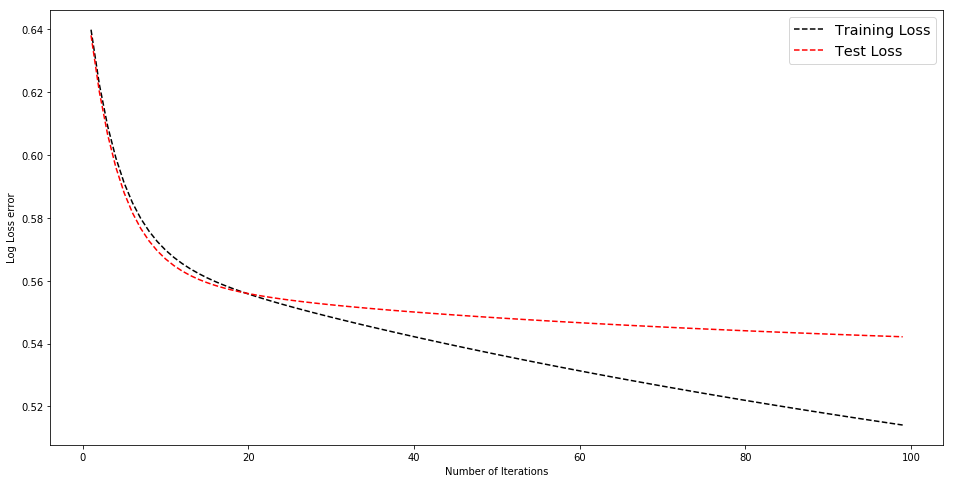

In [29]:
plotErrorCurves(train_loss_l, validation_loss_l)

## Hyperparameter Tuning Logistic Regression in Spark ML Implementation

### Run the Cross Validation Hyperparameter Tuning with the Training Sample data.

Note: A previous preliminary CV was run on the training sample data with ElasticNet parameters:  
$\lambda$ = 0.001, 0.01, 0.1, 1.0  
$\alpha$ = 0.001, 0.01, 0.1, 1.0 

The run shown below was only run with 2 levels for each hyperparameter, since it was informed by the preliminary results, as noted above, along with the "standard" run that was done with default values ($\lambda=0$ and $\alpha=0$), which resulted in better accuracy relative to using the preliminary CV grid. Therefore, we did this run on the extreme low end of hyperparameters near zero to see if the bestModel picked hyperparameter values different than zero.  As shown below, it indeed picked $\lambda$ = 0.001 and and $\alpha$ = 0 for the best model.  

In [20]:
tpp = spark.read.parquet('gs://w261_desa2/notebooks/data/toySampleTrain.parquet')
dpp = spark.read.parquet('gs://w261_desa2/notebooks/data/toySampleTest.parquet')
tpp.columns, dpp.columns

(['label', 'features', 'weightCol'], ['label', 'features'])

In [7]:
lr_sample_reg = LogisticRegression(
    featuresCol = 'features', 
    labelCol = 'label', 
    maxIter=10, 
    standardization=False
)

'''
lr_sample_reg = LogisticRegression(
    featuresCol = 'features', 
    labelCol = 'label', 
    weightCol = 'weightCol', 
    maxIter=10, 
    standardization=False)
'''
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_sample_reg.regParam, [0.000, 0.001]) \
    .addGrid(lr_sample_reg.elasticNetParam, [0.000, 0.001]) \
    .build()

crossval_lr_sample = CrossValidator(
    estimator=lr_sample_reg,
    estimatorParamMaps=paramGrid_lr,
    evaluator=BinaryClassificationEvaluator()
)

#fit model to training data
lr_sample_reg_model = crossval_lr_sample.fit(tpp)

In [8]:
#Transform test data
lr_sample_reg_result = lr_sample_reg_model.transform(dpp)

#view id, label, prediction and probability from result of modeling
lr_sample_reg_result.select('label', 'prediction', 'probability').show(10)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.91702852874526...|
|  0.0|       0.0|[0.51818982131679...|
|  0.0|       0.0|[0.85063532384838...|
|  0.0|       0.0|[0.88003037171912...|
|  0.0|       0.0|[0.65511546044695...|
|  0.0|       0.0|[0.91582283648407...|
|  0.0|       0.0|[0.84256585960662...|
|  0.0|       0.0|[0.80445812139920...|
|  0.0|       0.0|[0.62212235696704...|
|  0.0|       0.0|[0.60589380037474...|
+-----+----------+--------------------+
only showing top 10 rows



In [25]:
def metricsCalc(lp):
    '''
    Calculate binary classification metrics
    '''
    
    trueP = lp.filter(lp["prediction"] == 1.0).filter(lp["label"] == lp["prediction"]).count()
    trueN = lp.filter(lp["prediction"] == 0.0).filter(lp["label"] == lp["prediction"]).count()
    falseP = lp.filter(lp["prediction"] == 1.0).filter(lp["label"] != lp["prediction"]).count()
    falseN = lp.filter(lp["prediction"] == 0.0).filter(lp["label"] != lp["prediction"]).count()

    # Calculate precision, recall, accuracy, and F1
    precision = float(trueP)/(trueP + falseP) # aka specificity
    recall = float(trueP)/(trueP + falseN)  # aka sensitivity
    accuracy = float(trueP + trueN)/(trueP + trueN + falseP + falseN)
    if trueP != 0:
        f1 = 2 * (precision * recall) / (precision + recall)  # if trueP=0, then precision=0 and recall=0, so f1 doesn't work.
    else:
        f1 = 'TP=0 so cannot calc f1'

    # prints
    print('Number of records:', (trueP+falseP+trueN+falseN))
    print(f'trueP\t\t{trueP}')
    print(f'trueN\t\t{trueN}')
    print(f'falseP\t\t{falseP}')
    print(f'falseN\t\t{falseN}')
    print(f'accuracy\t{accuracy}')
    print(f'precision\t{precision}')
    print(f'recall\t\t{recall}')
    print(f'f1\t\t{f1}')

In [10]:
lp_reg = lr_sample_reg_result.select( "label", "prediction")
metricsCalc(lp_reg)

Number of records: 427
trueP		31
trueN		284
falseP		17
falseN		95
accuracy	0.7377049180327869
precision	0.6458333333333334
recall		0.24603174603174602
f1		0.3563218390804597


In [11]:
lr_sample_reg_model.getEstimatorParamMaps()[ np.argmax(lr_sample_reg_model.avgMetrics) ]

{Param(parent='LogisticRegression_43bda9c3e9b32eb32bd4', name='regParam', doc='regularization parameter (>= 0).'): 0.001,
 Param(parent='LogisticRegression_43bda9c3e9b32eb32bd4', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}

In [ ]:
#lr_sample_reg_model.save('gs://w261_desa2/notebooks/models/cvModel')

##### RESULT of HT using sample data: accuracy = 0.74 with $\lambda$ = 0.001 and $\alpha$ = 0.0.

### Read full training and test data and apply Logistic Regression with Tuned Hyperparameters chosen above.

In [13]:
train = spark.read.parquet('gs://w261_desa2/notebooks/data/trainProcessed.parquet')
test = spark.read.parquet('gs://w261_desa2/notebooks/data/testProcessed.parquet')

In [14]:
train.head()

Row(label=0.0, features=SparseVector(806981, {156: 1.0, 12535: 1.0, 12753: 1.0, 19354: 1.0, 35037: 1.0, 133078: 1.0, 133481: 1.0, 136576: 1.0, 212102: 1.0, 313588: 1.0, 411679: 1.0, 411685: 1.0, 411703: 1.0, 411723: 1.0, 414082: 1.0, 512854: 1.0, 520086: 1.0, 521530: 1.0, 615070: 1.0, 706347: 1.0, 707394: 1.0}), weightCol=0.25621744990348816)

In [15]:
test.head()

Row(label=0.0, features=SparseVector(806981, {90: 1.0, 12535: 1.0, 12645: 1.0, 19396: 1.0, 114451: 1.0, 133077: 1.0, 133469: 1.0, 136576: 1.0, 211551: 1.0, 238784: 1.0, 350583: 1.0, 411679: 1.0, 411685: 1.0, 411697: 1.0, 411972: 1.0, 428999: 1.0, 512762: 1.0, 520084: 1.0, 521530: 1.0, 615070: 1.0, 706348: 1.0, 710127: 1.0}))

In [225]:
train.columns

In [17]:
train.distinct().count()

41234939

In [16]:
test.distinct().count()

4587391

In [229]:
# Non-CV version

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=40)
lr_model = lr.fit(train)
trainingSummary = lr_model.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

"lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=40)\nlr_model = lr.fit(train)\ntrainingSummary = lr_model.summary\n\nroc = trainingSummary.roc.toPandas()\nplt.plot(roc['FPR'],roc['TPR'])\nplt.ylabel('False Positive Rate')\nplt.xlabel('True Positive Rate')\nplt.title('ROC Curve')\nplt.show()\nprint('Training set ROC: ' + str(trainingSummary.areaUnderROC))\n"

In [230]:
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)

In [231]:
objectiveHistory

In [ ]:
# Non-CV run

predictions_lr = lr_model.transform(test)
evaluator = BinaryClassificationEvaluator()
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})))

In [ ]:
lp_full = predictions_lr.select( "label", "prediction")
metricsCalc(lp_full)

Run below with $\lambda$ = 0.001 and $\alpha$ = 0.0, based on the hyperparameter tuning above (unweighted) done on the sample data.  

In [18]:
# Logisitic Regression with Regularization and Cross Validation for Hyperparameter Tuning

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 

lr_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=30)

paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_reg.regParam, [0.001]) \
    .addGrid(lr_reg.elasticNetParam, [0.0]) \
    .build()

crossval_lr = CrossValidator(estimator=lr_reg,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=5)

#fit model to training data
lr_reg_model = crossval_lr.fit(train)

#Transform test data
lr_reg_result = lr_reg_model.transform(test)

#view id, label, prediction and probability from result of modeling
lr_reg_result.select('label', 'prediction', 'probability').show(10)


+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.90175615546890...|
|  0.0|       0.0|[0.74411407594441...|
|  0.0|       0.0|[0.97631520901880...|
|  0.0|       0.0|[0.97374281970219...|
|  0.0|       1.0|[0.40851486911468...|
|  0.0|       0.0|[0.71834811786216...|
|  0.0|       0.0|[0.92212408812388...|
|  0.0|       0.0|[0.95423178577135...|
|  0.0|       0.0|[0.94699554388450...|
|  0.0|       0.0|[0.68850688970982...|
+-----+----------+--------------------+
only showing top 10 rows



In [19]:
lr_reg_model.getEstimatorParamMaps()[ np.argmax(lr_reg_model.avgMetrics) ]

{Param(parent='LogisticRegression_4d698991557597982245', name='regParam', doc='regularization parameter (>= 0).'): 0.001,
 Param(parent='LogisticRegression_4d698991557597982245', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}

In [39]:
#print('intercept:', lr_reg_model.bestModel.intercept)
#print('coefficients:', lr_reg_model.bestModel.coefficients)

In [21]:
lp_reg = lr_reg_result.select( "label", "prediction")
metricsCalc(lp_reg)

Number of records: 4587917
trueP		429346
trueN		3160106
falseP		252035
falseN		746430
accuracy	0.7823707360006731
precision	0.63011149415672
recall		0.365159690281142
f1		0.4623690942661283


In [23]:
lr_reg_model.save('gs://w261_desa2/notebooks/models/regFullModel_Steve')

##### RESULT using optimal hyperparameters and full data: accuracy = 0.78237 with $\lambda$ = 0.001 and $\alpha$ = 0.0.